names of the member

In [1]:
# system packages
import os
#import shutil
import sys

# data and numerical management packages
import pandas as pd
import numpy as np

# typing
from typing import List, Callable, Dict

## Part 1

Download the corpora and extract it, structuring a dataframe.

In [2]:
from urllib import request
import zipfile

print(f"Current work directory: {os.getcwd()}")
dataset_folder = os.path.join(os.getcwd(), "Datasets")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
dataset_path = os.path.join(dataset_folder, "Corpora.zip")
print(dataset_path)

def download_dataset(download_path: str, url: str):
    if not os.path.exists(download_path):
        print("Downloading dataset...")
        request.urlretrieve(url, download_path)
        print("Download complete!")

def extract_dataset(download_path: str, extract_path: str):
    print("Extracting dataset... (it may take a while...)")
    with zipfile.ZipFile(download_path) as loaded_zip:
        loaded_zip.extractall(extract_path)
    print("Extraction completed!")


download_dataset(dataset_path, url)
extract_dataset(dataset_path, dataset_folder)

Current work directory: C:\Users\fabian\Desktop\tutorial\homework1
C:\Users\fabian\Desktop\tutorial\homework1\Datasets\Corpora.zip
Extracting dataset... (it may take a while...)
Extraction completed!


In [3]:
def encode_dataset(dataset_name:str) -> pd.DataFrame:
    dataframe_rows = []
    folder = os.path.join(os.getcwd(), "Datasets", dataset_name)

    for filename in os.listdir(folder):   
        
        #doc = filename.split("_")[1].split(".")[0]
        #num = int(doc)
        
        # prepare the variable with the sentences of the document 
        sentences = ""
        labels = ""
        
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path):
                with open(file_path, mode='r', encoding='utf-8') as text_file:
                    
                    
                    # read every line, add the word and the corresponding label
                    lines = text_file.readlines()  
                    for line in lines:
                        if not line.isspace():                     
                            text = line.strip()
                            sentences = sentences + text.split('\t')[0] + " "
                            labels = labels + text.split('\t')[1] + " "
                            
                        
                        
       
                    
        except Exception as e:
            print('Failed to process %s. Reason: %s' % (file_path, e))
            sys.exit(0)
            
        # create single dataframe row and add it 
        dataframe_row = {
            "sentence": sentences,
            "label": labels
        }
        dataframe_rows.append(dataframe_row)

        
    folder = os.path.join(os.getcwd(), "Datasets", "Dataframes", dataset_name)
    if not os.path.exists(folder):
        os.makedirs(folder)
        
        
    # transform the list of rows in a proper dataframe
    df = pd.DataFrame(dataframe_rows)
    df = df[["sentence", "label"]]
    dataframe_path = os.path.join(folder, dataset_name + ".pkl")
    df.to_pickle(dataframe_path)
    
    return df                
    

In [4]:
print("Encoding dataset...")
df = encode_dataset(dataset_name='dependency_treebank')
print("Encoding completed!")

Encoding dataset...
Encoding completed!


In [5]:
# print example of first document

print(df.sentence[0])
print(df.label[0])

Pierre Vinken , 61 years old , will join the board as a nonexecutive director Nov. 29 . Mr. Vinken is chairman of Elsevier N.V. , the Dutch publishing group . 
NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN NNP CD . NNP NNP VBZ NN IN NNP NNP , DT NNP VBG NN . 


### Pre Processing data

In [6]:
from functools import reduce

In [7]:
# define function that lower case the text

def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    """
    return text.lower()

In [8]:
# define the preprocessing operation that we have to do 
PREPROCESSING_PIPELINE = [lower]

# define function that execute all the operation in preprocessing_pipeline
def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    return reduce(lambda txt, f: f(txt), filter_methods, text)

In [9]:
# apply the preprocess 
df.sentence = df.sentence.apply(lambda txt: text_prepare(txt))
df.label = df.label.apply(lambda txt: text_prepare(txt))

In [10]:
# print the same example after the preprocessing
print(df.sentence[0])
print(df.label[0])

pierre vinken , 61 years old , will join the board as a nonexecutive director nov. 29 . mr. vinken is chairman of elsevier n.v. , the dutch publishing group . 
nnp nnp , cd nns jj , md vb dt nn in dt jj nn nnp cd . nnp nnp vbz nn in nnp nnp , dt nnp vbg nn . 


In [11]:
# compute the total number of words and tag label

num_words = len(set([word for i in range(df.shape[0]) for word in df.sentence[i].split() ]))
num_tags   = len(set([word for i in range(df.shape[0]) for word in df.label[i].split()]))

In [12]:
print("Total number of tagged sentences: {}".format(len(df.sentence)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 199
Vocabulary size: 10947
Total number of tags: 45


In [13]:
# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print("Length of first input sequence  : {}".format(len(df.sentence[0].split())))
print("Length of first output sequence : {}".format(len(df.label[0].split())))

Length of first input sequence  : 31
Length of first output sequence : 31


### Tokenizer

In [14]:
from keras.preprocessing.text import Tokenizer

In [15]:
# encode X

word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts([df.sentence[i].split() for i in range(df.shape[0])])                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences([df.sentence[i].split() for i in range(df.shape[0])])  # use the tokeniser to encode input sequence

In [16]:
# encode Y, same way of X

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(df.label[i].split() for i in range(df.shape[0]))
Y_encoded = tag_tokenizer.texts_to_sequences(df.label[i].split() for i in range(df.shape[0]))

In [17]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', df.sentence[0], '\n')
print('Y: ', df.label[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')



** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  pierre vinken , 61 years old , will join the board as a nonexecutive director nov. 29 . mr. vinken is chairman of elsevier n.v. , the dutch publishing group .  

Y:  nnp nnp , cd nns jj , md vb dt nn in dt jj nn nnp cd . nnp nnp vbz nn in nnp nnp , dt nnp vbg nn .  


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [5419, 3714, 1, 2005, 78, 316, 1, 39, 2383, 2, 122, 22, 6, 2006, 317, 444, 2007, 3, 26, 3714, 15, 167, 4, 5420, 2890, 1, 2, 2891, 621, 137, 3] 

Y:  [3, 3, 7, 9, 5, 6, 7, 20, 12, 4, 1, 2, 4, 6, 1, 3, 9, 8, 3, 3, 16, 1, 2, 3, 3, 7, 4, 3, 18, 1, 8] 



In [18]:
import re

In [19]:
# save the label for each sentences that are not punctation

tagg = re.compile('[a-z]') # re for label that are letter nad not punctation

good_idxs = [] # save the indexes of label that are not punctation

# for all the sentences, see all the labels and save the one that are not punctation
for j in range(df.shape[0]):
    good_idx = []
    
    for i in range(len(df.sentence[j].split())):
        if tagg.search(df.label[j].split()[i]) and Y_encoded[j][i] not in good_idx:
             good_idx.append(Y_encoded[j][i])
   
    good_idx = np.sort(good_idx)
    good_idxs.append(good_idx)
    


In [20]:
# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


### Split data in train, val and test set

In [21]:
from keras.utils import pad_sequences

In [22]:
# Pad each sequence to max_seq_length using KERAS' pad_sequences() function. 
# Sentences longer than max_seq_length are truncated.
# Sentences shorter than max_seq_length are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'post' padding type, that is, add zeroes on the right side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

max_seq_length = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=max_seq_length, padding="post", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=max_seq_length, padding="post", truncating="post")



In [23]:
# print the first sequence
print(X_padded[0])
print(Y_padded[0])

[5419 3714    1 2005   78  316    1   39 2383    2  122   22    6 2006
  317  444 2007    3   26 3714   15  167    4 5420 2890    1    2 2891
  621  137    3    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[ 3  3  7  9  5  6  7 20 12  4  1  2  4  6  1  3  9  8  3  3 16  1  2  3
  3  7  4  3 18  1  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


In [24]:
print(X_padded.shape)
print(Y_padded.shape)

(199, 100)
(199, 100)


In [25]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

In [26]:
from keras.utils.np_utils import to_categorical

In [27]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [28]:
# divide the df in train, val and test set
x_train = X[:100]
y_train = Y[:100]
x_val = X[100:150]
y_val = Y[100:150]
x_test = X[150:200]
y_test = Y[150:200]

In [29]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(x_train.shape))
print('Shape of output sequences: {}'.format(y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(x_val.shape))
print('Shape of output sequences: {}'.format(y_val.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(x_test.shape))
print('Shape of output sequences: {}'.format(y_test.shape))

TRAINING DATA
Shape of input sequences: (100, 100)
Shape of output sequences: (100, 100, 46)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (50, 100)
Shape of output sequences: (50, 100, 46)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (49, 100)
Shape of output sequences: (49, 100, 46)


In [30]:
num_classes = y_train.shape[2] # number of classes

## Part 2

### Vocabulary

Embed the words using GloVe embeddings

In [31]:
import gensim
import gensim.downloader as gloader

In [32]:
embedding_dimension = 50 # [50, 100, 200, 300] possibility
# download and load the vocabulary glove
download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
embedding_model = gloader.load(download_path)

In [33]:
# assign word vectors from glove model

vocab_size = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_vector = np.zeros((vocab_size, embedding_dimension))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from glove model to the words present in corpus, OOV words set to 0
for word, index in word2id.items():
    try:
        embedding_vector[index] = embedding_model[word]
    except KeyError:
        embedding_vector [index] = np.zeros(embedding_dimension) 



In [34]:
# check embedding dimension
print("Embeddings shape: {}".format(embedding_vector.shape))

Embeddings shape: (10948, 50)


In [35]:
# print an example
embedding_vector[word_tokenizer.word_index['pierre']]

array([ 0.23568   ,  0.39638001, -0.60135001, -0.52680999,  0.15877999,
        0.035317  , -1.38549995, -0.050794  , -0.59138   ,  0.28227001,
        0.75602001,  0.17395   , -1.4483    ,  0.18503   ,  0.33835   ,
       -0.71196997,  0.93379998, -1.1688    , -0.064745  , -0.63867003,
       -0.46408999,  1.1839    , -0.43759   , -0.089778  , -0.95805001,
        0.012933  , -0.64701003, -0.28791001,  0.071964  ,  1.43089998,
        0.44505   , -0.27070999, -1.6473    ,  0.006484  ,  0.46397001,
       -0.21664999,  0.1401    ,  0.91751999,  1.12779999,  1.44350004,
        0.85627002,  1.25049996,  0.39963999, -1.38629997, -0.331     ,
        0.48466   , -1.45039999, -0.2049    ,  0.77636999,  0.23190001])


## Part 3

baseline model
BiLSTM and TimeDistributed Dense

In [36]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, TimeDistributed, Dense, Embedding
import keras
import matplotlib.pyplot as plt

In [37]:
# create architecture

bidirectional_model = Sequential()
bidirectional_model.add(Embedding(input_dim     = vocab_size,
                             output_dim    = embedding_dimension,
                             input_length  = max_seq_length,
                             weights       = [embedding_vector],
                             trainable     = False
))
bidirectional_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirectional_model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

In [38]:
bidirectional_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [39]:
bidirectional_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           547400    
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         58880     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 46)          5934      
 ibuted)                                                         
                                                                 
Total params: 612,214
Trainable params: 64,814
Non-trainable params: 547,400
_________________________________________________________________


In [40]:
bidirectional_train = bidirectional_model.fit(x_train, y_train, batch_size=10, epochs = 20, validation_data=(x_val, y_val))

Epoch 1/20
10/10 [==============================] - 4s 122ms/step - loss: 3.5719 - acc: 0.1784 - val_loss: 3.2383 - val_acc: 0.1936
Epoch 2/20
10/10 [==============================] - 0s 38ms/step - loss: 3.0654 - acc: 0.2548 - val_loss: 2.8851 - val_acc: 0.2376
Epoch 3/20
10/10 [==============================] - 0s 37ms/step - loss: 2.7041 - acc: 0.3275 - val_loss: 2.7037 - val_acc: 0.2792
Epoch 4/20
10/10 [==============================] - 0s 38ms/step - loss: 2.4406 - acc: 0.3446 - val_loss: 2.5581 - val_acc: 0.3258
Epoch 5/20
10/10 [==============================] - 0s 39ms/step - loss: 2.2680 - acc: 0.4110 - val_loss: 2.4180 - val_acc: 0.3674
Epoch 6/20
10/10 [==============================] - 0s 38ms/step - loss: 2.1342 - acc: 0.4376 - val_loss: 2.2915 - val_acc: 0.4048
Epoch 7/20
10/10 [==============================] - 0s 36ms/step - loss: 2.0121 - acc: 0.4737 - val_loss: 2.1652 - val_acc: 0.4342
Epoch 8/20
10/10 [==============================] - 0s 36ms/step - loss: 1.8901 - 

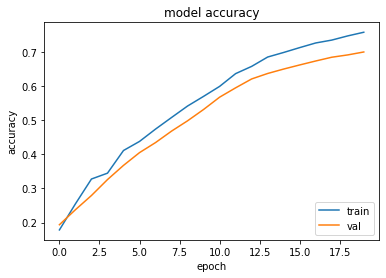

In [41]:
# visualise training history
plt.plot(bidirectional_train.history['acc'])
plt.plot(bidirectional_train.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

## Part 4

experiment doing small modification

### Architecture 1

Gru and Time Distributed Dense

In [42]:
from keras.layers import GRU

In [43]:
# create architecture

GRU_model = Sequential()
GRU_model.add(Embedding(input_dim     = vocab_size,
                             output_dim    = embedding_dimension,
                             input_length  = max_seq_length,
                             weights       = [embedding_vector],
                             trainable     = False
))
GRU_model.add(GRU(64, return_sequences=True))
GRU_model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

In [44]:
GRU_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [45]:
GRU_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           547400    
                                                                 
 gru (GRU)                   (None, 100, 64)           22272     
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 46)          2990      
 tributed)                                                       
                                                                 
Total params: 572,662
Trainable params: 25,262
Non-trainable params: 547,400
_________________________________________________________________


In [46]:
GRU_train = GRU_model.fit(x_train, y_train, batch_size=10, epochs = 20, validation_data=(x_val, y_val))

Epoch 1/20
10/10 [==============================] - 2s 72ms/step - loss: 3.7311 - acc: 0.1565 - val_loss: 3.4907 - val_acc: 0.1696
Epoch 2/20
10/10 [==============================] - 0s 27ms/step - loss: 3.3397 - acc: 0.2420 - val_loss: 3.1010 - val_acc: 0.1856
Epoch 3/20
10/10 [==============================] - 0s 27ms/step - loss: 3.0180 - acc: 0.1721 - val_loss: 2.8871 - val_acc: 0.1940
Epoch 4/20
10/10 [==============================] - 0s 26ms/step - loss: 2.8169 - acc: 0.2722 - val_loss: 2.7629 - val_acc: 0.3102
Epoch 5/20
10/10 [==============================] - 0s 26ms/step - loss: 2.5918 - acc: 0.3689 - val_loss: 2.6605 - val_acc: 0.3214
Epoch 6/20
10/10 [==============================] - 0s 27ms/step - loss: 2.3958 - acc: 0.4083 - val_loss: 2.4765 - val_acc: 0.3936
Epoch 7/20
10/10 [==============================] - 0s 27ms/step - loss: 2.2088 - acc: 0.4512 - val_loss: 2.3205 - val_acc: 0.4194
Epoch 8/20
10/10 [==============================] - 0s 27ms/step - loss: 2.0588 - a

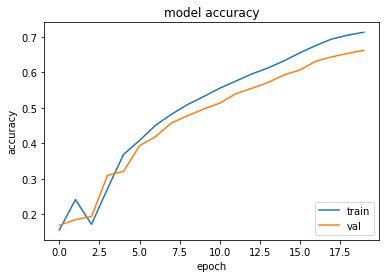

In [47]:
# visualise training history
plt.plot(GRU_train.history['acc'])
plt.plot(GRU_train.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

### Architecture 2

2 LSTM layer and Time Distributed Dense

In [48]:
# create architecture

doublebidir_model = Sequential()
doublebidir_model.add(Embedding(input_dim     = vocab_size,
                             output_dim    = embedding_dimension,
                             input_length  = max_seq_length,
                             weights       = [embedding_vector],
                             trainable     = False
))
doublebidir_model.add(Bidirectional(LSTM(64, return_sequences=True)))
doublebidir_model.add(Bidirectional(LSTM(64, return_sequences=True)))
doublebidir_model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

In [49]:
doublebidir_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [50]:
doublebidir_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           547400    
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 128)         58880     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 128)         98816     
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 46)          5934      
 tributed)                                                       
                                                                 
Total params: 711,030
Trainable params: 163,630
Non-trainable params: 547,400
__________________________________________

In [51]:
doublebidir_train = doublebidir_model.fit(x_train, y_train, batch_size=10, epochs = 20, validation_data=(x_val, y_val))

Epoch 1/20
10/10 [==============================] - 7s 231ms/step - loss: 3.4702 - acc: 0.1434 - val_loss: 3.0913 - val_acc: 0.1728
Epoch 2/20
10/10 [==============================] - 1s 67ms/step - loss: 2.9323 - acc: 0.2505 - val_loss: 2.8735 - val_acc: 0.2128
Epoch 3/20
10/10 [==============================] - 1s 67ms/step - loss: 2.6107 - acc: 0.2895 - val_loss: 2.7620 - val_acc: 0.2298
Epoch 4/20
10/10 [==============================] - 1s 67ms/step - loss: 2.4630 - acc: 0.3053 - val_loss: 2.6844 - val_acc: 0.2362
Epoch 5/20
10/10 [==============================] - 1s 68ms/step - loss: 2.3885 - acc: 0.3179 - val_loss: 2.6021 - val_acc: 0.2770
Epoch 6/20
10/10 [==============================] - 1s 69ms/step - loss: 2.3078 - acc: 0.3505 - val_loss: 2.5151 - val_acc: 0.3000
Epoch 7/20
10/10 [==============================] - 1s 68ms/step - loss: 2.2189 - acc: 0.3828 - val_loss: 2.4175 - val_acc: 0.3288
Epoch 8/20
10/10 [==============================] - 1s 66ms/step - loss: 2.1135 - 

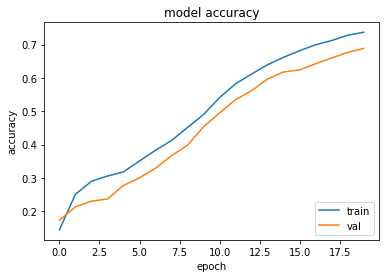

In [52]:
# visualise training history
plt.plot(doublebidir_train.history['acc'])
plt.plot(doublebidir_train.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

 ### Architecture 3
 
 2 Time Distributed Dense

In [53]:
# create architecture

doubledense_model = Sequential()
doubledense_model.add(Embedding(input_dim     = vocab_size,
                             output_dim    = embedding_dimension,
                             input_length  = max_seq_length,
                             weights       = [embedding_vector],
                             trainable     = False
))
doubledense_model.add(Bidirectional(LSTM(64, return_sequences=True)))
doubledense_model.add(TimeDistributed(Dense(num_classes, activation='softmax')))
doubledense_model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

In [54]:
doubledense_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [55]:
doubledense_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 50)           547400    
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 128)         58880     
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 100, 46)          5934      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 100, 46)          2162      
 tributed)                                                       
                                                                 
Total params: 614,376
Trainable params: 66,976
Non-trainable params: 547,400
___________________________________________

In [56]:
doubledense_train = doubledense_model.fit(x_train, y_train, batch_size=10, epochs = 20, validation_data=(x_val, y_val))

Epoch 1/20
10/10 [==============================] - 4s 117ms/step - loss: 3.8100 - acc: 0.0631 - val_loss: 3.7838 - val_acc: 0.1504
Epoch 2/20
10/10 [==============================] - 0s 36ms/step - loss: 3.7558 - acc: 0.1133 - val_loss: 3.7177 - val_acc: 0.1048
Epoch 3/20
10/10 [==============================] - 0s 36ms/step - loss: 3.7014 - acc: 0.0989 - val_loss: 3.6859 - val_acc: 0.1170
Epoch 4/20
10/10 [==============================] - 0s 37ms/step - loss: 3.6740 - acc: 0.1087 - val_loss: 3.6627 - val_acc: 0.1128
Epoch 5/20
10/10 [==============================] - 0s 37ms/step - loss: 3.6449 - acc: 0.1213 - val_loss: 3.6400 - val_acc: 0.1118
Epoch 6/20
10/10 [==============================] - 0s 37ms/step - loss: 3.6181 - acc: 0.2063 - val_loss: 3.6185 - val_acc: 0.1570
Epoch 7/20
10/10 [==============================] - 0s 37ms/step - loss: 3.5910 - acc: 0.2450 - val_loss: 3.5974 - val_acc: 0.1570
Epoch 8/20
10/10 [==============================] - 0s 36ms/step - loss: 3.5673 - 

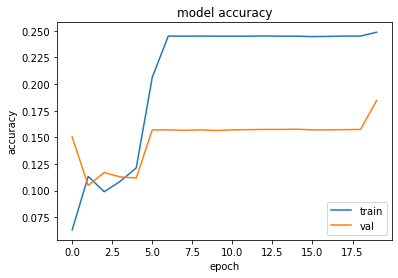

In [57]:
# visualise training history
plt.plot(doubledense_train.history['acc'])
plt.plot(doubledense_train.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

## Part 5

### Evaluate yourt best 2 model

as we can see from the val_loss the best two model are the base model, with 1 layer biLSTM and 1 TimeDistributed, and the architecture 2, with 2 layer biLSTM and 1 TimeDistributed

In [58]:
from sklearn.metrics import f1_score

In [59]:
# function that predict the data with a model given in input

def predict_data(model: keras.Model,
                 x: np.ndarray,
                 prediction_info: Dict) -> np.ndarray:
    
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples in np.ndarray format
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels in np.ndarray format
    """
    print(f'Starting prediction: \n{prediction_info}')
    print(f'Predicting on {x.shape[0]} samples')
    predictions = model.predict(x, **prediction_info)
    return predictions

In [60]:
# parameters of prediction
prediction_info = {
    'batch_size': 10,
    'verbose': 1
}

In [61]:
# predict the data with the first model 
y_pred_bidi = predict_data(model=bidirectional_model, x=x_test,
                                      prediction_info=prediction_info)
y_pred_bidi = np.argmax(y_pred_bidi, axis=-1) # remove padding

Starting prediction: 
{'batch_size': 10, 'verbose': 1}
Predicting on 49 samples
5/5 [==============================] - 1s 10ms/step


In [62]:
# predict the data with the second model 
y_pred_doubledir = predict_data(model=doublebidir_model, x=x_test,
                                      prediction_info=prediction_info)
y_pred_doubledir = np.argmax(y_pred_doubledir, axis=-1) # remove padding

Starting prediction: 
{'batch_size': 10, 'verbose': 1}
Predicting on 49 samples
5/5 [==============================] - 2s 19ms/step


In [63]:
# remove padding
y_test_max = np.argmax(y_test, axis=-1)

In [64]:
# function that compute the F1 score from the y_true and y_predicted

def evaluate_predictions(predictions: np.ndarray,
                         y: np.ndarray):
    
    scoreF1 = []
    # for every sentences compute the F1 score, then compute the F1 score of all the test set
    for i in range(y_test_max.shape[0]):

        #ignore the labels that are punctation
        scoreF1.append(f1_score(y_true=y[i], y_pred=predictions[i], average='macro', labels=good_idxs[i], zero_division=0))
        
    return (sum(scoreF1) / len(scoreF1))
    

In [65]:
# compute F1 score of first model
F1_bidi = evaluate_predictions(y_pred_bidi, y_test_max)
print(F1_bidi)

0.4242829261076708


In [66]:
# compute F1 score of second model
F1_doubledir = evaluate_predictions(predictions=y_pred_doubledir, y = y_test_max)
print(F1_doubledir)

0.399444702274652


The first model (Bidirectional LSTM and Dense/Fully-Connected layer) has a slightly better F1 score than the other model (2 Bidirectional LSTM and 1 Dense/Fully-Connected layer), so it's the best model

## Part 6

## Analyze the errors


I will do the classification report and confusion matrix only for the first sentences

In [67]:
# remove padding
y_train_max = np.argmax(y_train, axis=-1)
y_val_max = np.argmax(y_val, axis=-1)

In [68]:
from sklearn.dummy import DummyClassifier

# initiate dummy classifier
maj_classifier = DummyClassifier(strategy="prior", random_state=52)
uni_classifier = DummyClassifier(strategy="uniform", random_state=52)

# fit with the train set
maj_classifier.fit(x_train, y_train_max)
uni_classifier.fit(x_train, y_train_max)

# use the classifier to predict value for validation and test set
y_pred_val_maj = maj_classifier.predict(x_val)
y_pred_val_uni = uni_classifier.predict(x_val)
y_pred_test_maj = maj_classifier.predict(x_test)
y_pred_test_uni = uni_classifier.predict(x_test)

MAJORITY
R2 score -0.879841
MAE 6.491800
MSE 91.041400

              precision    recall  f1-score   support

           1       0.24      0.50      0.33        16
           2       0.00      0.00      0.00        20
           3       0.20      0.30      0.24        10
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         8
           9       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         0

   micro avg       0.20      0.14      0.16        79
   macro avg       0.04      0.07      0.05        79
weighted avg       0.07      0.14      0.10        79

R2 score -0.822612
MAE 5.990408
MSE 78.947959

              precision    recall  f1-score   support

           1       0.12      

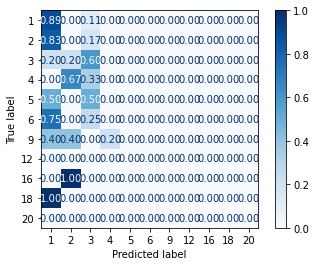

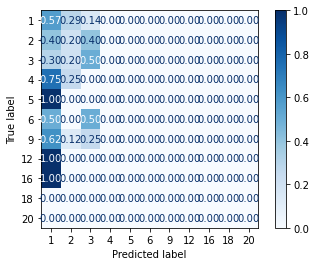

In [69]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


print("MAJORITY")
# task as regression

# val set

r2_maj_val = r2_score(y_val_max, y_pred_val_maj)
mae_maj_val = mean_absolute_error(y_val_max, y_pred_val_maj)
mse_maj_val = mean_squared_error(y_val_max, y_pred_val_maj)

print("R2 score %f" % r2_maj_val)
# Mean Absolute Error
print("MAE %f" % mae_maj_val)
# Mean Squared Error
print("MSE %f" % mse_maj_val)
print()

# classification report and confusion matrix for val set

report = classification_report(y_val_max[0], y_pred_val_maj[0], zero_division=0, labels=good_idxs[0])
print(report)

ConfusionMatrixDisplay.from_predictions(y_val_max[0], y_pred_val_maj[0], normalize='true', cmap=plt.cm.Blues, values_format=".2f", labels=good_idxs[0])



# test set

r2_maj_test = r2_score(y_test_max, y_pred_test_maj)
mae_maj_test = mean_absolute_error(y_test_max, y_pred_test_maj)
mse_maj_test = mean_squared_error(y_test_max, y_pred_test_maj)

print("R2 score %f" % r2_maj_test)
# Mean Absolute Error
print("MAE %f" % mae_maj_test)
# Mean Squared Error
print("MSE %f" % mse_maj_test)
print()

# classification report and confusion matrix for test set

report = classification_report(y_test_max[0], y_pred_test_maj[0], zero_division=0, labels=good_idxs[0])
print(report)

ConfusionMatrixDisplay.from_predictions(y_test_max[0], y_pred_test_maj[0], normalize='true', cmap=plt.cm.Blues, values_format=".2f", labels=good_idxs[0])


The R2 should be positive, but we have it negative so it isn't good

MAE and MSE should be lower as possible, the MSE is pretty big

The first and third class have better value than other class both in validation and test set

We have terrible accuracy

Validation and test result are pretty similar so they are coherent



mojority probabilmente meglio se predecta meglio quelle nel mezzo e non estremi



In [70]:
print("RANDOM UNIFORM")
# task as regression

# val set

r2_uni_val = r2_score(y_val_max, y_pred_val_uni)
mae_uni_val = mean_absolute_error(y_val_max, y_pred_val_uni)
mse_uni_val = mean_squared_error(y_val_max, y_pred_val_uni)

print("R2 score %f" % r2_uni_val)
# Mean Absolute Error
print("MAE %f" % mae_uni_val)
# Mean Squared Error
print("MSE %f" % mse_uni_val)
print()


# classification report for val set

report = classification_report(y_val_max[0], y_pred_val_uni[0], labels=good_idxs[0], zero_division=0)
print(report)


# test set

r2_uni_test = r2_score(y_test_max, y_pred_test_uni)
mae_uni_test = mean_absolute_error(y_test_max, y_pred_test_uni)
mse_uni_test = mean_squared_error(y_test_max, y_pred_test_uni)

print("R2 score %f" % r2_uni_test)
# Mean Absolute Error
print("MAE %f" % mae_uni_test)
# Mean Squared Error
print("MSE %f" % mse_uni_test)
print()


# classification report for test set

report = classification_report(y_test_max[0], y_pred_test_uni[0], labels=good_idxs[0], zero_division=0)
print(report)



RANDOM UNIFORM
R2 score -2.418199
MAE 9.548200
MSE 149.423400

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00        20
           3       0.20      0.10      0.13        10
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         8
           9       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         0

   micro avg       0.02      0.01      0.02        79
   macro avg       0.02      0.01      0.01        79
weighted avg       0.03      0.01      0.02        79

R2 score -2.860245
MAE 9.634286
MSE 152.421633

              precision    recall  f1-score   support

           1       0.

THe R2 score, MAE and MSE are worse than majority classifier, probably because the majority class is the 3 in validation and 5 in test, and not an extremes

We can see that with a random classifier all the value are pretty bad, a lot of 0 or pretty near both in validation and test set



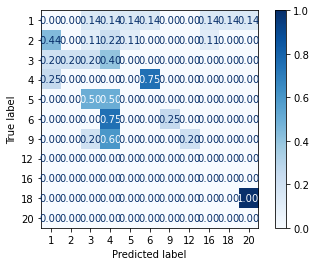

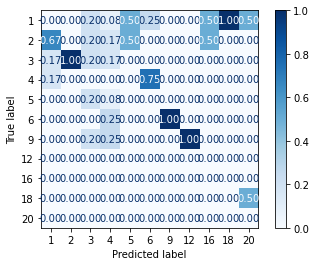

In [71]:
# confusion matrix for val set changing normalization

ConfusionMatrixDisplay.from_predictions(y_val_max[0], y_pred_val_uni[0], normalize='true', cmap=plt.cm.Blues, values_format=".2f", labels=good_idxs[0])

ConfusionMatrixDisplay.from_predictions(y_val_max[0], y_pred_val_uni[0], normalize='pred', cmap=plt.cm.Blues, values_format=".2f", labels=good_idxs[0])


The first confusion matrix shows us if we have good recall or not, while the second shows the precision

We can see that only for label 3 we have "good" value

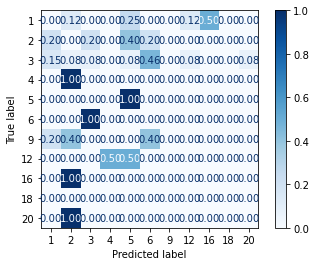

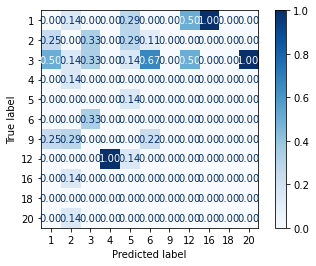

In [72]:
# confusion matrix for test set changing normalization

ConfusionMatrixDisplay.from_predictions(y_test_max[0], y_pred_test_uni[0], normalize='true', cmap=plt.cm.Blues, values_format=".2f", labels=good_idxs[0])

ConfusionMatrixDisplay.from_predictions(y_test_max[0], y_pred_test_uni[0], normalize='pred', cmap=plt.cm.Blues, values_format=".2f", labels=good_idxs[0])


In the test set we can see that also the label 5 is not bad, in particular the recall is 0.5

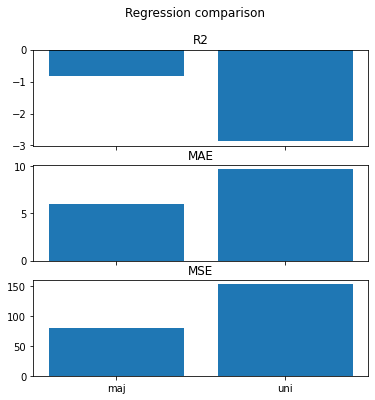

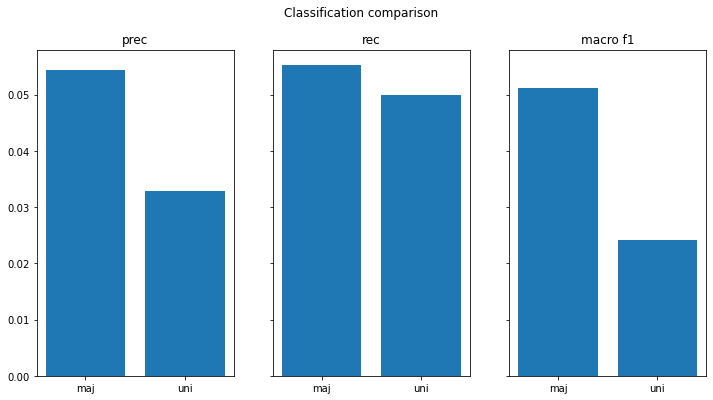

In [73]:
from sklearn.metrics import precision_recall_fscore_support as prfs

# plot the value obtained in the classification report for the test set

fig, plots = plt.subplots(3, sharex=True, figsize=(6, 6))
fig.suptitle('Regression comparison')
plots[0].bar(["maj","uni"], [r2_maj_test, r2_uni_test])
plots[0].set_title("R2")
plots[1].bar(["maj","uni"], [mae_maj_test, mae_uni_test])
plots[1].set_title("MAE")
plots[2].bar(["maj","uni"], [mse_maj_test, mse_uni_test])
plots[2].set_title("MSE")

plt.show()

prfs_maj = prfs(y_test_max[0], y_pred_test_maj[0], labels=good_idxs[0], average="macro", zero_division=0)
prfs_uni = prfs(y_test_max[0], y_pred_test_uni[0], labels=good_idxs[0], average="macro", zero_division=0)

fig2, plots = plt.subplots(1,3, sharey=True, figsize=(12, 6))
fig2.suptitle('Classification comparison')
plots[0].bar(["maj","uni"], [prfs_maj[0], prfs_uni[0]])
plots[0].set_title("prec")
plots[1].bar(["maj","uni"], [prfs_maj[1], prfs_uni[1]])
plots[1].set_title("rec")
plots[2].bar(["maj","uni"], [prfs_maj[2], prfs_uni[2]])
plots[2].set_title("macro f1")

plt.show()

Here we compare majority and uniform classifier and we can see that the majority one performs better for everything

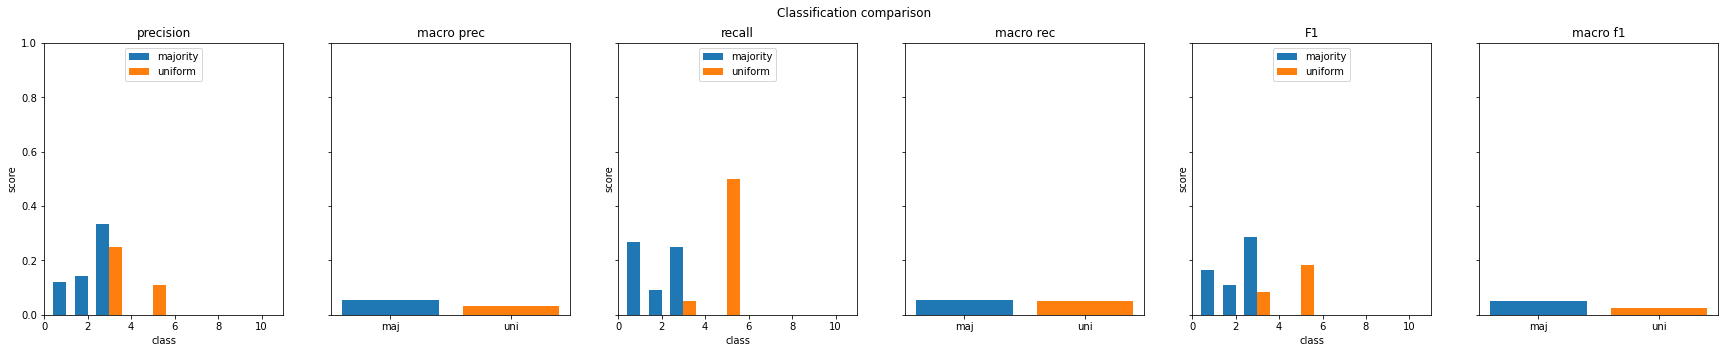

In [74]:

# plot the precision, recall, F1, macro precision, macro recall and macro F1 for every class 

prfs_maj = prfs(y_test_max[0], y_pred_test_maj[0], labels=good_idxs[0], average=None, zero_division=0)
prfs_uni = prfs(y_test_max[0], y_pred_test_uni[0], labels=good_idxs[0], average=None, zero_division=0)

prfs_maj_macro = prfs(y_test_max[0], y_pred_test_maj[0], labels=good_idxs[0], average="macro", zero_division=0)
prfs_uni_macro = prfs(y_test_max[0], y_pred_test_uni[0], labels=good_idxs[0], average="macro", zero_division=0)

plt.show()


fig1, plots = plt.subplots(1,6, sharey=True, figsize=(30, 5))
fig1.suptitle('Classification comparison')


width=0.3

plots[0].bar(good_idxs[0]-width, prfs_maj[0], width*2, label="majority", color="tab:blue")
plots[0].bar(good_idxs[0]+width, prfs_uni[0], width*2, label="uniform", color="tab:orange")
plots[0].set_title("precision")

plots[0].set_ylim([0,1])
plots[0].set_xlim([0,11])
plots[0].set_xlabel("class")
plots[0].set_ylabel("score")
plots[0].legend(loc='upper center')

plots[1].bar(["maj","uni"], [prfs_maj_macro[0], prfs_uni_macro[0]], color=["tab:blue", "tab:orange"])
plots[1].set_title("macro prec")
plots[3].bar(["maj","uni"], [prfs_maj_macro[1], prfs_uni_macro[1]], color=["tab:blue", "tab:orange"])
plots[3].set_title("macro rec")
plots[5].bar(["maj","uni"], [prfs_maj_macro[2], prfs_uni_macro[2]], color=["tab:blue", "tab:orange"])
plots[5].set_title("macro f1")

plots[2].bar(good_idxs[0]-width, prfs_maj[1], width*2, label="majority")
plots[2].bar(good_idxs[0]+width, prfs_uni[1], width*2, label="uniform")
plots[2].set_title("recall")

plots[2].set_ylim([0,1])
plots[2].set_xlim([0,11])
plots[2].set_xlabel("class")
plots[2].set_ylabel("score")
plots[2].legend(loc='upper center')


plots[4].bar(good_idxs[0]-width, prfs_maj[2], width*2, label="majority")
plots[4].bar(good_idxs[0]+width, prfs_uni[2], width*2, label="uniform")
plots[4].set_title("F1")

plots[4].set_ylim([0,1])
plots[4].set_xlim([0,11])
plots[4].set_xlabel("class")
plots[4].set_ylabel("score")
plots[4].legend(loc='upper center')

plt.show()


Here we can see graphs for the value in the classification report

We can notice that majority has better precision than uniform and has value for 3 class instead of 2, in macro prec we can see that the majority is a bigger.

The uniform has a class with big recall, while majority has more class with similar value, in fact in macro recall majority and uniform have almost the same value

In F1_score, like the precision and recall, we can notice that majority is better or quite similar to the uniform around all class, and that in macro F1 is quite better.